In [ ]:
import pandas as pd
import warnings
import re
import requests, zipfile, io, os
import numpy as np
from tensorflow import keras
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler, StandardScaler
warnings.filterwarnings('ignore')

In [ ]:
# download file from url, extract it and store it in the dest_folder
def download_and_extract(url, dest_folder):
  r = requests.get(url)
  z = zipfile.ZipFile(io.BytesIO(r.content))
  z.extractall(dest_folder)

In [ ]:
# define folders and urls
healthy_path = './healthy'
healthy_url = 'http://wwwp.fc.unesp.br/~papa/pub/datasets/Handpd/NewHealthy/Signal.zip'
parkinson_path = './parkinson'
parkinson_url = 'http://wwwp.fc.unesp.br/~papa/pub/datasets/Handpd/NewPatients/Signal.zip'

In [ ]:
download_and_extract(healthy_url, healthy_path)

In [ ]:
download_and_extract(parkinson_url, parkinson_path)

In [ ]:
# actual downloaded signals
healthy_signals = f'{healthy_path}/Signal/'
parkinson_signals = f'{parkinson_path}/Signal/'

In [ ]:
# define Input and labels (0 = healthy, parkinson = 1)
X = []
y = []
seq = 100

In [ ]:
# create dataset with sequence length

# healthy signals
for filename in os.listdir(healthy_signals):
  if re.search('sigSp', filename) is not None:
    df = pd.read_csv(healthy_signals + filename, sep='\s+', header=None, comment='#')
    count = len(df.index) // seq
    for i in range(count):
      X.append((df.iloc[i * seq : (i + 1) * seq]).to_numpy())
      y.append(0)

# parkinson signals
for filename in os.listdir(parkinson_signals):
  if re.search('sigSp', filename) is not None:
    df = pd.read_csv(parkinson_signals + filename, sep='\s+', header=None, comment='#')
    count = len(df.index) // seq
    for i in range(count):
      X.append((df.iloc[i * seq : (i + 1) * seq]).to_numpy())
      y.append(1) 


In [ ]:
len(X)

46901

In [ ]:
# convert lists to np arrays
X = np.array(X)
y = np.array(y)

In [ ]:
X.shape

(46901, 100, 6)

In [ ]:
y.shape

(46901,)

In [ ]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2)

In [ ]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train.reshape(-1, X_train.shape[-1])).reshape(X_train.shape)
X_valid = scaler.transform(X_valid.reshape(-1, X_valid.shape[-1])).reshape(X_valid.shape)


In [ ]:
model = keras.models.Sequential([
keras.layers.GRU(512, return_sequences=True, input_shape=(X_train.shape[1], 6)),
keras.layers.Dropout(0.5),
keras.layers.GRU(256),
keras.layers.Dropout(0.5),
keras.layers.Dense(1, activation="sigmoid")
])


In [ ]:
model.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])


In [ ]:
checkpoint_filepath = "model.h5"
model_checkpoint_callback = keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True)

In [ ]:
history = model.fit(X_train, y_train, epochs = 100, batch_size = 32, validation_data=(X_valid, y_valid), callbacks=[model_checkpoint_callback])

Epoch 1/100
1173/1173 [==============================] - 25s 22ms/step - loss: 0.4870 - accuracy: 0.7755 - val_loss: 0.4242 - val_accuracy: 0.8047
Epoch 2/100
1173/1173 [==============================] - 25s 21ms/step - loss: 0.3750 - accuracy: 0.8319 - val_loss: 0.3217 - val_accuracy: 0.8620
Epoch 3/100
1173/1173 [==============================] - 25s 21ms/step - loss: 0.3560 - accuracy: 0.8428 - val_loss: 0.3095 - val_accuracy: 0.8689
Epoch 4/100
1173/1173 [==============================] - 25s 21ms/step - loss: 0.2965 - accuracy: 0.8733 - val_loss: 0.2613 - val_accuracy: 0.8886
Epoch 5/100
1173/1173 [==============================] - 25s 21ms/step - loss: 0.2583 - accuracy: 0.8918 - val_loss: 0.2554 - val_accuracy: 0.8957
Epoch 6/100
1173/1173 [==============================] - 25s 21ms/step - loss: 0.2909 - accuracy: 0.8729 - val_loss: 0.3766 - val_accuracy: 0.8343
Epoch 7/100
1173/1173 [==============================] - 25s 21ms/step - loss: 0.3306 - accuracy: 0.8557 - val_loss: 0

KeyboardInterrupt: ignored

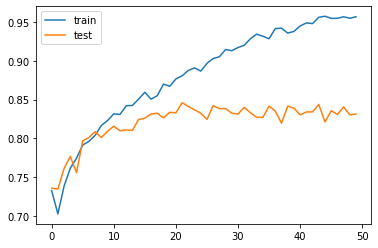

In [ ]:
# 100
plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label='test')
plt.legend()
plt.show()

In [ ]:
# 3000
plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label='test')
plt.legend()
plt.show()

In [ ]:
model.load_weights(checkpoint_filepath)
model.evaluate(X_valid, y_valid)

In [ ]:
!ls

In [ ]:
from google.colab import files
files.download('model.h5') 